# ** Описание **

In [24]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import random
import warnings

import numpy as np

from collections import namedtuple
from collections import Counter
from collections import OrderedDict
from recordclass import recordclass

from sklearn.base import TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RandomizedLogisticRegression

from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [25]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [26]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [27]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def to_unicode(text):
    if not isinstance(text, unicode): text = text.decode('utf8')
    return text
    
def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [28]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [29]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [30]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [31]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [32]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [33]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [34]:
from HTMLParser import HTMLParser

# create a subclass and override the handler methods
class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.html = 0
        self.head = 0
        self.title = 0
        self.body = 0
        self.a = 0
        self.title_data = ''
        self.anchor_data = ''
        self.all_data = ''
        
    def handle_starttag(self, tag, attrs):
        if tag == 'html':
            self.html += 1
        if tag == 'head':
            self.head += 1
        if tag == 'title':
            self.title += 1
        if tag == 'body':
            self.body += 1
        if tag == 'a':
            self.a += 1

    def handle_endtag(self, tag):
        if tag == 'html':
            self.html -= 1
        if tag == 'head':
            self.head -= 1
        if tag == 'title':
            self.title -= 1
        if tag == 'body':
            self.body -= 1
        if tag == 'a':
            self.a -= 1

    def handle_data(self, data):
        if self.html == 1 and self.head == 1 and self.title == 1:
            self.title_data += data + ' '
        if self.html == 1 and self.body == 1 and self.a == 1:
            self.anchor_data += data + ' '
        self.all_data += data + ' '
            
    def get_title_words(self):
        return filter(None, map(str.rstrip, re.split(' ', to_utf8(self.title_data))))

    def get_anchor_words(self):
        return filter(None, map(str.rstrip, re.split(' ', to_utf8(self.anchor_data))))  
    
    def get_all_words(self):
        return filter(lambda word : len(word) < 11, filter(None, map(str.rstrip, re.split(' ', to_utf8(self.all_data)))))
    
    def get_all_text(self):
        self.all_data = re.sub('[(\r\n|\r|\n)]+', ' ', self.all_data)
        self.all_data = re.sub(u'[^0-9a-zA-Zа-яА-Я ]+', '', self.all_data)
        self.all_data = re.sub(' +', ' ', self.all_data)
        return self.all_data

In [35]:
def calc_features(url, html_data):
    parser = MyHTMLParser()
    parser.feed(to_unicode(html_data))
    
    words = list(html2word(html_data))
    title_words = parser.get_title_words()
    anchor_words = parser.get_anchor_words()
    
    words_num = len(words) #0
    avg_word_len = 0 
    for word in words:
        avg_word_len += len(word)
    avg_word_len /= words_num #1
    title_words_num = len(title_words)     #2
    anchor_words_num = len(anchor_words)    #3
    compression_level = float(len(to_utf8(html_data).encode('zlib'))) / len(html_data) #4
    
    simple_features = [len(words), avg_word_len, title_words_num, anchor_words_num, compression_level]
    
    return simple_features, parser.get_all_text(), parser.get_all_words()

In [36]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'

features, text, words = calc_features(test_url, test_html_data)

print features
print text
print words
for word in words:
    print word

[6, 3.5, 0, 0, 1.1833333333333333]
 Заголовок Ololo спам 1 2 3 
['Ololo', '\xd1\x81\xd0\xbf\xd0\xb0\xd0\xbc', '1', '2', '3']
Ololo
спам
1
2
3


In [37]:
from multiprocessing import Process, Queue

DocItem = recordclass('DocItem', ['doc_id', 'is_spam', 'url', 'features', 'text', 'words'])

WORKER_NUM = 8

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features, text, words = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features, text, words)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            #features, text, words = calc_features_f(url, html_data)            
            features = []
            words = []
            text = re.sub(u'[^0-9a-zA-Zа-яА-Я ]+', '', html_data)
            res_queue.put(DocItem(url_id, mark, url, features, text, words))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in xrange(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [38]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))

23:44:50 INFO:Complete items 07043 in worker_id 2
23:44:50 INFO:Complete items 07043 in worker_id 1
23:44:51 INFO:Complete items 07043 in worker_id 6
23:44:51 INFO:Complete items 07043 in worker_id 3
23:44:51 INFO:Complete items 07043 in worker_id 4
23:44:51 INFO:Complete items 07043 in worker_id 5
23:44:51 INFO:Complete items 07043 in worker_id 0
23:44:51 INFO:Complete items 07043 in worker_id 7


CPU times: user 458 ms, sys: 2.51 s, total: 2.96 s
Wall time: 10.5 s


In [40]:
train_texts = []
train_labels = []

for doc in train_docs:
    train_texts.append(doc.text)
    train_labels.append(doc.is_spam)

In [41]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(train_texts, train_labels, test_size=0.33)

In [42]:
# Model using TfIdf on words

words_model = Pipeline([('CV', CountVectorizer(analyzer='word', stop_words=None, min_df=0.1, max_df=0.8, ngram_range=[1,3])),
                        ('TfIdf', TfidfTransformer()),
                        ('XGB', XGBClassifier(n_estimators=1500, max_deepth = 13, n_jobs=12))])

In [43]:
# Model using TfIdf on chars

chars_model = Pipeline([('CV', CountVectorizer(analyzer='char', stop_words=None, ngram_range=[1,3])),
                        ('TfIdf', TfidfTransformer()),
                        ('XGB', XGBClassifier(n_estimators=1500, max_deepth=13, n_jobs=12))])

In [44]:
# combine models

voiting_model = VotingClassifier(estimators=[('word', words_model), 
                                             ('char', chars_model)
                                            ], 
                                 voting='soft', 
                                 n_jobs=24)

voiting_model.fit(X_train_train, y_train_train)

y_train_test_predict_voiting = voiting_model.predict(X_train_test)
print "Voiting model: ", roc_auc_score(y_train_test_predict_voiting, y_train_test), f1_score(y_train_test_predict_voiting, y_train_test)

Voiting model:  0.9748992008883064 0.9792130660727544


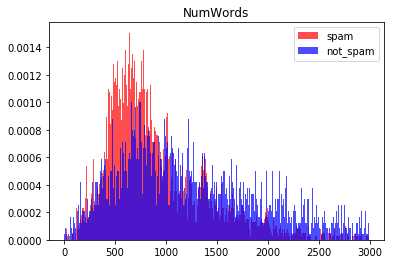

In [249]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

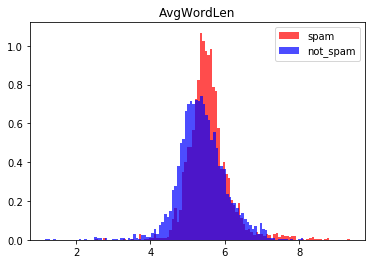

In [250]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

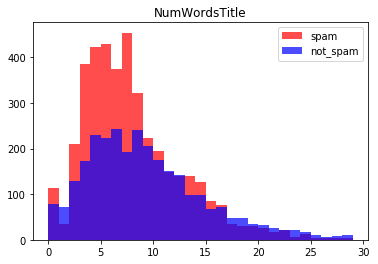

In [251]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=False, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=False, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

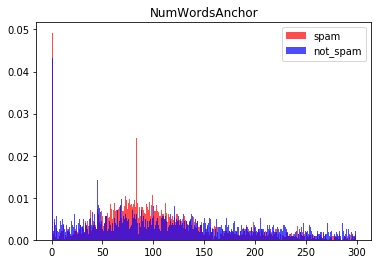

In [252]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 300, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

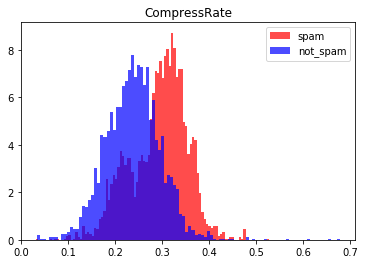

In [253]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('CompressRate')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [45]:
class Classifier:
    
    def __init__(self):
        
        self.chars_model = Pipeline([('CV', CountVectorizer(analyzer='char', stop_words=None, ngram_range=[1,3])),
                                     ('TfIdf', TfidfTransformer()),
                                     ('XGB', XGBClassifier(n_estimators=1500, max_deepth=13, n_jobs=12))])
        
        self.words_model = Pipeline([('CV', CountVectorizer(analyzer='word', stop_words=None, min_df=0.1, max_df=0.8, ngram_range=[1,3])),
                                     ('TfIdf', TfidfTransformer()),
                                     ('XGB', XGBClassifier(n_estimators=1500, max_deepth = 13, n_jobs=12))])
        
        self.model = VotingClassifier(estimators=[('word', words_model), 
                                                  ('char', chars_model)], 
                                      voting='soft', 
                                      n_jobs = 24)

    def predict(self, doc):
        result = self.model.predict([doc.text])
        return result
        
    def predict_all(self, docs):
        result = []
        for doc_num, doc in enumerate(docs):   
            result.append((doc.doc_id, doc.is_spam, doc.url, self.predict(doc)))            
            trace(doc_num)
        return result
    
    def train(self, train_texts, train_labels):
        self.model.fit(train_texts, train_labels)

In [46]:
classifier = Classifier()
classifier.train(train_texts, train_labels)

** Рисуем графики **

In [47]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.1, trace=1)

00:03:40 INFO:Complete items 00000
00:08:43 INFO:Complete items 01000
00:11:02 INFO:Complete items 02000
00:15:06 INFO:Complete items 03000


KeyboardInterrupt: 

In [48]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

00:18:43 INFO:Complete items 16038 in worker_id 1
00:18:44 INFO:Complete items 16038 in worker_id 4
00:18:44 INFO:Complete items 16038 in worker_id 0
00:18:44 INFO:Complete items 16038 in worker_id 3
00:18:45 INFO:Complete items 16038 in worker_id 6
00:18:45 INFO:Complete items 16038 in worker_id 5
00:18:45 INFO:Complete items 16038 in worker_id 2
00:18:45 INFO:Complete items 16038 in worker_id 7


CPU times: user 1.66 s, sys: 2.09 s, total: 3.75 s
Wall time: 19.9 s


In [49]:
threshold = 0.61

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

00:18:46 INFO:Complete items 00000
00:22:19 INFO:Complete items 01000
00:28:09 INFO:Complete items 02000
00:31:30 INFO:Complete items 03000
00:37:49 INFO:Complete items 04000
00:41:34 INFO:Complete items 05000
00:45:24 INFO:Complete items 06000
00:51:23 INFO:Complete items 07000
00:54:12 INFO:Complete items 08000
01:00:33 INFO:Complete items 09000
01:04:44 INFO:Complete items 10000
01:11:31 INFO:Complete items 11000
01:16:20 INFO:Complete items 12000
01:20:01 INFO:Complete items 13000
01:26:26 INFO:Complete items 14000
01:30:32 INFO:Complete items 15000
01:35:50 INFO:Complete items 16000
